In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,r2_score
import xgboost as xgb
from matplotlib import pyplot as plt

In [2]:
data_dir = "F:/TARGET frontier/TXT33/"
train_data = pd.read_csv(data_dir+"sample2_fe.csv",encoding="shift-jis")#na_values=['--']

In [3]:
#data型がobjectになっていることがあるので、intもしくはfloatになおしてやる
columns = train_data.columns

for i in columns:
    #print(i)
    dtype = train_data[i].dtype
    if dtype != "int64" and dtype != "float64":
        train_data[i] = train_data[i].astype("float64")

In [4]:
pd.set_option('display.max_columns', 100)
train_data.head()

,場所,芝・ダ,距離,クラス名,馬場状態,騎手コード,枠番,性別,年齢,キャリア,斤量,間隔,休み明け〜戦目,種牡馬,父タイプ名,調教師コード,前走場所,前芝・ダ,前距離,前クラス名,前走馬場状態,前走騎手コード,前走枠番,前走脚質,前走斤量,前走Ave-3F,前走上り3F,前走PCI3,前走RPCI,前PCI,前好走,前走平均1Fタイム,前走着差タイム,前走単勝オッズ,着差,レースID(旧),複勝オッズ下限,複勝オッズ上限,複勝配当,単勝オッズ
0,1,1,1600,0,3,1092,7,2,5,17,57.0,4.0,4.0,133,4,1162,1,2,1600.0,4,3,1092.0,6.0,3,57.0,36.12,34.1,55.93,54.0,55.9,0,11.79,-0.0,2.8,-0.2,619241214,2.1,2.7,230.0,6.2
1,1,1,1600,0,3,1169,5,0,5,16,56.0,8.0,5.0,172,4,386,2,2,1600.0,2,3,1167.0,3.0,2,54.0,35.10,35.0,48.93,43.8,50.3,0,11.69,0.7,8.5,0.2,619241209,2.2,2.9,240.0,7.2
2,1,1,1600,0,3,666,6,2,5,17,57.0,17.0,1.0,239,6,1020,13,2,1600.0,2,3,1150.0,5.0,3,57.0,37.02,33.5,61.77,59.9,60.5,0,11.90,0.6,11.8,0.4,619241211,2.8,3.8,300.0,9.2
3,1,1,1600,0,3,1014,4,1,4,11,55.0,4.0,3.0,275,6,1054,13,2,1800.0,4,3,1014.0,7.0,3,54.0,37.10,33.9,61.00,59.0,59.4,0,12.01,-0.4,2.6,0.6,619241208,1.9,2.4,0.0,4.6
4,1,1,1600,0,3,5212,8,1,4,9,55.0,3.0,4.0,255,6,1097,13,2,1600.0,2,3,5212.0,7.0,3,55.0,37.26,33.4,62.07,61.0,61.6,0,11.94,0.3,3.3,0.9,619241216,1.8,2.2,0.0,5.1


In [5]:
train_x = train_data.drop(["着差","レースID(旧)","複勝オッズ下限","複勝オッズ上限","複勝配当"],axis=1)
train_y = train_data["着差"]

In [6]:
train_y.dtype

dtype('float64')

In [7]:
#xgboostのparams
params = {
    'booster':'gbtree',
    'objective':'reg:squarederror',
    'eta':0.1,
    'gamma':0.0,
    'alpha':0.0,
    'lambda':1.0,
    'min_child_weight':1,
    'max_depth':5,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'random_state':71,
}

In [8]:
#これがないとエラー履くので注意
train_y.fillna(1,inplace=True)

In [9]:
scores = []
histories = []
models = []
kf = KFold(n_splits=4,shuffle=False)
for tr_idx,va_idx in kf.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    dtrain = xgb.DMatrix(tr_x,label=tr_y)
    dvalid = xgb.DMatrix(va_x,label=va_y)
    watchlist = [(dtrain,"train"),(dvalid,"eval")]
    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        early_stopping_rounds=50,
        evals=watchlist,
        evals_result=evals_result,
        verbose_eval=10
    )
    models.append(model)
    histories.append(evals_result)
    va_pred = model.predict(dvalid)
    va_y.fillna(0.5,inplace=True) #ここまでok
    #print(va_pred[:10])
    #print(va_y[:10])
    score = r2_score(va_y,va_pred)
    scores.append(score)

print(*scores)
print(np.mean(scores))

[0]	train-rmse:1.57878	eval-rmse:1.85727
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.16024	eval-rmse:1.51232
[20]	train-rmse:1.04034	eval-rmse:1.43428


C:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[30]	train-rmse:0.986207	eval-rmse:1.40401
[40]	train-rmse:0.950569	eval-rmse:1.39208
[50]	train-rmse:0.918543	eval-rmse:1.38773
[60]	train-rmse:0.890598	eval-rmse:1.38152
[70]	train-rmse:0.864472	eval-rmse:1.38704
[80]	train-rmse:0.841249	eval-rmse:1.38589
[90]	train-rmse:0.820244	eval-rmse:1.38442
[100]	train-rmse:0.795803	eval-rmse:1.38457
Stopping. Best iteration:
[58]	train-rmse:0.895103	eval-rmse:1.38066

[0]	train-rmse:1.6843	eval-rmse:1.51391
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.21606	eval-rmse:1.19895
[20]	train-rmse:1.06706	eval-rmse:1.13583
[30]	train-rmse:1.00139	eval-rmse:1.12931


C:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[40]	train-rmse:0.956228	eval-rmse:1.12599
[50]	train-rmse:0.924147	eval-rmse:1.12555
[60]	train-rmse:0.895066	eval-rmse:1.12426
[70]	train-rmse:0.87077	eval-rmse:1.12518
[80]	train-rmse:0.845457	eval-rmse:1.12706
[90]	train-rmse:0.825814	eval-rmse:1.12736
[100]	train-rmse:0.804691	eval-rmse:1.1278
Stopping. Best iteration:
[54]	train-rmse:0.910672	eval-rmse:1.12354

[0]	train-rmse:1.62347	eval-rmse:1.70229
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.16702	eval-rmse:1.34049
[20]	train-rmse:1.02271	eval-rmse:1.27553


C:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[30]	train-rmse:0.96421	eval-rmse:1.26555
[40]	train-rmse:0.922461	eval-rmse:1.26269
[50]	train-rmse:0.89228	eval-rmse:1.26607
[60]	train-rmse:0.862479	eval-rmse:1.26731
[70]	train-rmse:0.843874	eval-rmse:1.26754
[80]	train-rmse:0.82018	eval-rmse:1.26615
[90]	train-rmse:0.807283	eval-rmse:1.26955
Stopping. Best iteration:
[40]	train-rmse:0.922461	eval-rmse:1.26269

[0]	train-rmse:1.67752	eval-rmse:1.52511
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.19249	eval-rmse:1.19069
[20]	train-rmse:1.04659	eval-rmse:1.16708


C:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[30]	train-rmse:0.97971	eval-rmse:1.17735
[40]	train-rmse:0.933862	eval-rmse:1.18556
[50]	train-rmse:0.905294	eval-rmse:1.19035
[60]	train-rmse:0.876476	eval-rmse:1.20269
[70]	train-rmse:0.852511	eval-rmse:1.2095
Stopping. Best iteration:
[22]	train-rmse:1.03134	eval-rmse:1.16464

0.32635032527864805 0.31380145163532014 0.3305588129632062 0.21479967581092763
0.2963775664220255


In [10]:
#学習結果のプロット
%matplotlib inline
def plot_loss(evals_result, title):
    train_metric = evals_result['train']['rmse']
    plt.plot(train_metric, label='train rmse')
    eval_metric = evals_result['eval']['rmse']
    plt.plot(eval_metric, label='eval rmse')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.xlabel('rounds')
    plt.ylabel('rmse')
    plt.show()

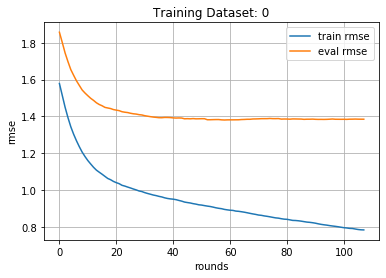

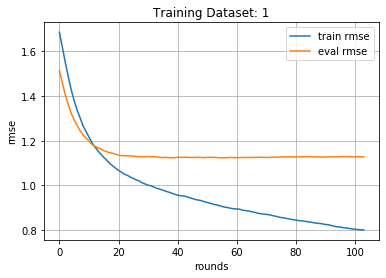

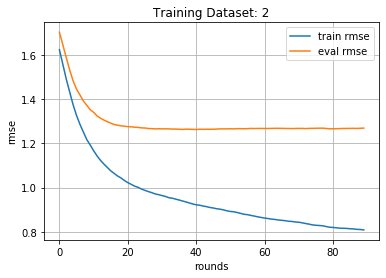

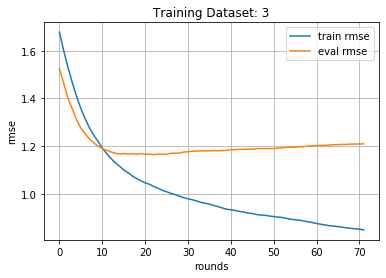

In [11]:
for i in range(4):
    plot_loss(histories[i],f'Training Dataset: {i}')

In [16]:
#ここに予測データを入れる(DataFrame形式)
test_data = train_y


test_length = len(test_data)
predict = np.array([0.0]*test_length)
dtest = xgb.DMatrix(train_x,label=train_y) #本来は学習に使用していないデータにする
for i in range(4):
    y_pred_proba = models[i].predict(dtest)
    predict += y_pred_proba

predict /= 4

C:\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [17]:
models

In [21]:
y = pd.DataFrame(predict,columns=["y'"])
output = train_data #ここも書き換えること

output = pd.concat([output,y],axis=1)
output["複勝配当"] = output["複勝配当"].astype("int64")
output.to_csv("C:/programs/HRP/neweval.csv",index=False,encoding="shift-jis")

In [19]:
output.head()

,場所,芝・ダ,距離,クラス名,馬場状態,騎手コード,枠番,性別,年齢,キャリア,斤量,間隔,休み明け〜戦目,種牡馬,父タイプ名,調教師コード,前走場所,前芝・ダ,前距離,前クラス名,前走馬場状態,前走騎手コード,前走枠番,前走脚質,前走斤量,前走Ave-3F,前走上り3F,前走PCI3,前走RPCI,前PCI,前好走,前走平均1Fタイム,前走着差タイム,前走単勝オッズ,着差,レースID(旧),複勝オッズ下限,複勝オッズ上限,複勝配当,単勝オッズ,y'
0,1,1,1600,0,3,1092,7,2,5,17,57.0,4.0,4.0,133,4,1162,1,2,1600.0,4,3,1092.0,6.0,3,57.0,36.12,34.1,55.93,54.0,55.9,0,11.79,-0.0,2.8,-0.2,619241214,2.1,2.7,230,6.2,0.465040
1,1,1,1600,0,3,1169,5,0,5,16,56.0,8.0,5.0,172,4,386,2,2,1600.0,2,3,1167.0,3.0,2,54.0,35.10,35.0,48.93,43.8,50.3,0,11.69,0.7,8.5,0.2,619241209,2.2,2.9,240,7.2,0.570949
2,1,1,1600,0,3,666,6,2,5,17,57.0,17.0,1.0,239,6,1020,13,2,1600.0,2,3,1150.0,5.0,3,57.0,37.02,33.5,61.77,59.9,60.5,0,11.90,0.6,11.8,0.4,619241211,2.8,3.8,300,9.2,0.575465
3,1,1,1600,0,3,1014,4,1,4,11,55.0,4.0,3.0,275,6,1054,13,2,1800.0,4,3,1014.0,7.0,3,54.0,37.10,33.9,61.00,59.0,59.4,0,12.01,-0.4,2.6,0.6,619241208,1.9,2.4,0,4.6,0.405895
4,1,1,1600,0,3,5212,8,1,4,9,55.0,3.0,4.0,255,6,1097,13,2,1600.0,2,3,5212.0,7.0,3,55.0,37.26,33.4,62.07,61.0,61.6,0,11.94,0.3,3.3,0.9,619241216,1.8,2.2,0,5.1,0.344577


In [43]:
for i,j in enumerate(output.columns):
    print(i,j)

0 場所
1 芝・ダ
2 距離
3 クラス名
4 馬場状態
5 騎手コード
6 枠番
7 性別
8 年齢
9 キャリア
10 斤量
11 間隔
12 休み明け〜戦目
13 種牡馬
14 父タイプ名
15 調教師コード
16 前走場所
17 前芝・ダ
18 前距離
19 前クラス名
20 前走馬場状態
21 前走騎手コード
22 前走枠番
23 前走脚質
24 前走斤量
25 前走Ave-3F
26 前走上り3F
27 前走PCI3
28 前走RPCI
29 前PCI
30 前好走
31 前走平均1Fタイム
32 前走着差タイム
33 前走単勝オッズ
34 着差
35 レースID(旧)
36 複勝オッズ下限
37 複勝オッズ上限
38 複勝配当
39 単勝オッズ
40 y'
